In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import scipy.stats as st
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


In [3]:
data=pd.read_csv("data.csv",parse_dates=['paidAt'])

# Resampling the data

In [31]:
amount_daily= data.resample(rule = 'd',on='paidAt').amount.sum()
amountfinancedbyXepelin_daily = data.resample(rule = 'd',on='paidAt').amountfinancedByXepelin.sum()
daily = pd.concat([amount_daily, amountfinancedbyXepelin_daily], axis=1).reset_index()

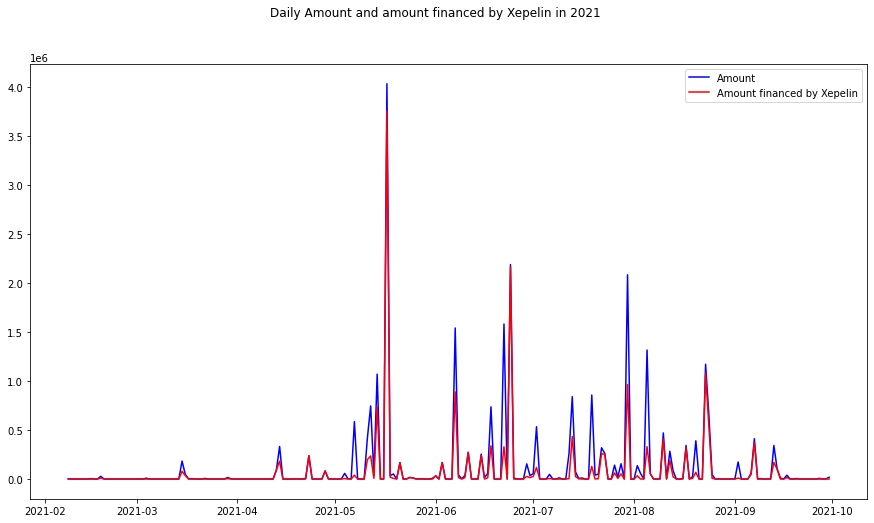

In [32]:
plt.subplots(figsize=(15,8))
plt.plot(daily.paidAt,daily.amount,color='blue',label="Amount")
plt.plot(daily.paidAt,daily.amountfinancedByXepelin,color='red',label="Amount financed by Xepelin")
plt.legend()
plt.suptitle("Daily Amount and amount financed by Xepelin in 2021")
plt.show()

**There is a clear correlation between amount and amount Xepelin. However, they both look like very erratic time series, with a lot of noise and irregularity, both in the amounts as well as the dates of the amounts. We will look at the weekly resample to see if is it has a nicer distribution.**

In [33]:
amount_weekly = data.resample(rule = 'W',on='paidAt').amount.sum()
amountfinancedbyXepelin_weekly = data.resample(rule = 'W',on='paidAt').amountfinancedByXepelin.sum()
weekly = pd.concat([amount_weekly, amountfinancedbyXepelin_weekly], axis=1).reset_index()

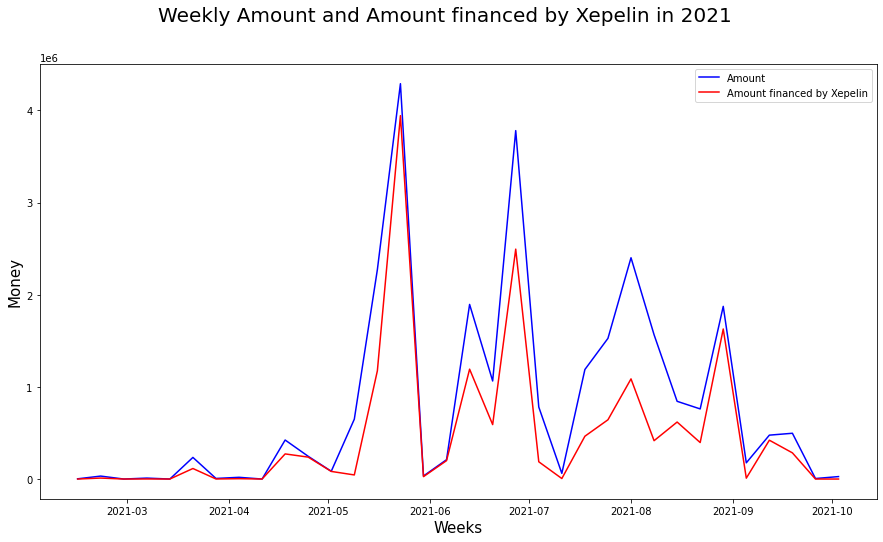

In [43]:
plt.subplots(figsize=(15,8))
plt.plot(weekly.paidAt,weekly.amount,color='blue',label="Amount")
plt.plot(weekly.paidAt,weekly.amountfinancedByXepelin,color='red',label="Amount financed by Xepelin")
plt.legend()
plt.suptitle("Weekly Amount and Amount financed by Xepelin in 2021",fontsize=20)
plt.ylabel("Money",fontsize=15)
plt.xlabel("Weeks",fontsize=15)
plt.show()


**This looks better, yet this time series has no trend, nor seasonality, nor constant variance or mean throughout time. It is on the contrary erratic and noisy. It will be a challenge to find a model that can forecast accurately without overfitting**

## Relationship between amount and amount financed by Xepelin

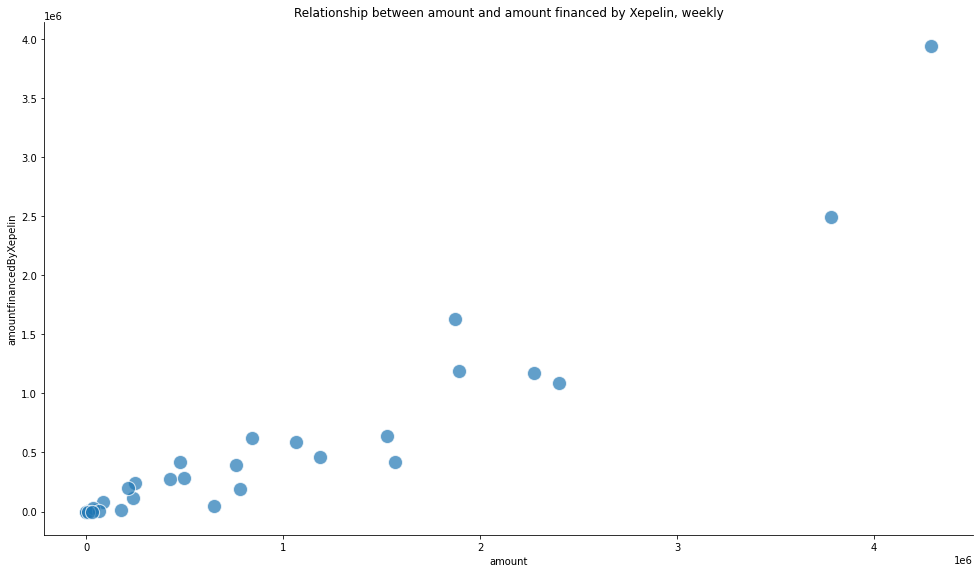

In [12]:
sns.relplot(height=8, aspect=12/7,x='amount',y='amountfinancedByXepelin',alpha=0.7,s=200,data=weekly)
plt.title("Relationship between amount and amount financed by Xepelin, weekly")
plt.show()

**As it can be appreciated in the figure above, there is a clear linear correlation between the two variables, so it makes absolute sense to fit a linear regression to explain amount Xepelin from amount. This way we will only have to predict the values of amount, and later on use the linear regression to calculate amount financed by xepelin.**

In [13]:
import numpy as np

In [14]:
X = np.array(weekly.amount).reshape(-1,1)
y = np.array(weekly.amountfinancedByXepelin)
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

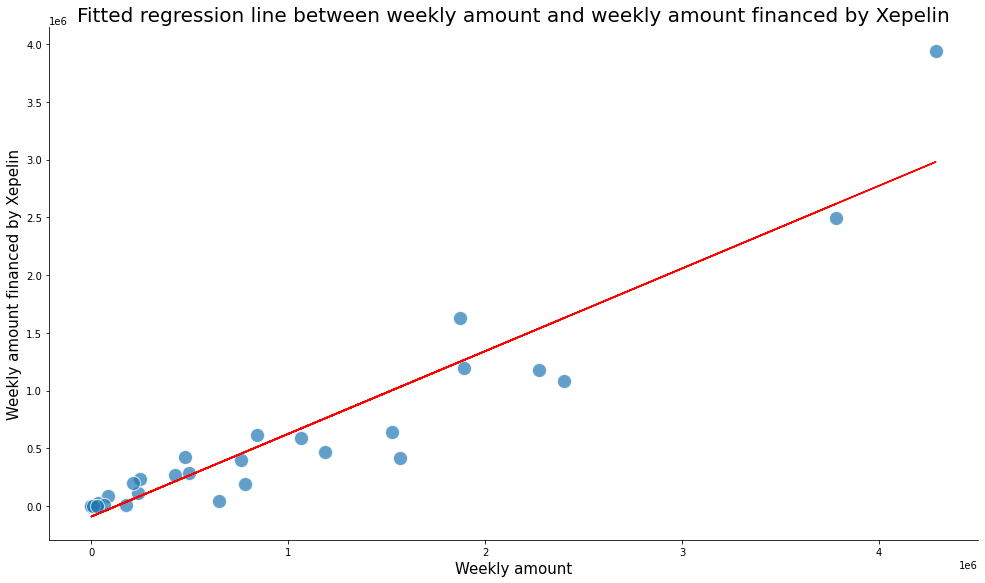

In [42]:
sns.relplot(height=8, aspect=12/7,x='amount',y='amountfinancedByXepelin',alpha=0.7,s=200,data=weekly)
plt.plot(X, lm.predict(X),color='red')
plt.xlabel("Weekly amount",fontsize=15)
plt.ylabel("Weekly amount financed by Xepelin",fontsize=15)
plt.title("Fitted regression line between weekly amount and weekly amount financed by Xepelin",fontsize=20)
plt.show()

In [23]:
print("The R^2 of the linear regression between amount and amount financed by Xepelin is {}%. This means that {}% of the variability of Amount financed by Xepelin around its mean is explained by the model.".format(round(lm.score(X,y)*100,2),round(lm.score(X,y)*100,2)))

The R^2 of the linear regression between amount and amount financed by Xepelin is 88.94%. This means that 88.94% of the variability of Amount financed by Xepelin around its mean is explained by the model.


# Predicting AMOUNT for October 2021

**We will use the last 5 weeks as test set (15% of data points), and the first 24 weeks as train set. This is clearly not optimal since there is very little data points.**

In [259]:
train_set = weekly.iloc[:29,]
test_set = weekly.iloc[29:,]

## Median of weekly amount

In [149]:
median_array = np.repeat(train_set.amount.median(), 5)

In [263]:
print("The test RMSE of the median forecast is {}, while the train RMSE is {}. What this tells us is that about 68% of the models predictions fall within $283187 of the actual value.".format(round(mean_squared_error(median_array,np.array(test_set.amount))**(1/2),2),round(mean_squared_error(np.repeat(train_set.amount.median(), 29),np.array(train_set.amount))**(1/2),2)))

The test RMSE of the median forecast is 283187.25, while the train RMSE is 1227317.3.    What this tells us is that about 68% of the models predictions fall within $283187 of the actual value.


## Simple Exponential Smoothing

In [264]:
alpha = [0,0.0001,0.001,0.01,0.2,0.4,0.6,0.8]
for i in alpha:
    model = SimpleExpSmoothing(train_set.amount).fit(smoothing_level=i)
    forecast = np.array(model.forecast(5))
    rmse_train=mean_squared_error(model.fittedvalues,np.array(train_set.amount))**(1/2)
    rmse_test=mean_squared_error(forecast,np.array(test_set.amount))**(1/2)
    print("For smoothing level {} the train RMSE is {} and the test RMSE is {}.".format(i,round(rmse_train,2),round(rmse_test,2)))


For smoothing level 0 the train RMSE is 1128709.0 and the test RMSE is 701701.01.
For smoothing level 0.0001 the train RMSE is 1128770.67 and the test RMSE is 698679.15.
For smoothing level 0.001 the train RMSE is 1129279.54 and the test RMSE is 695876.64.
For smoothing level 0.01 the train RMSE is 1133064.47 and the test RMSE is 713345.85.
For smoothing level 0.2 the train RMSE is 1082145.97 and the test RMSE is 1156448.81.
For smoothing level 0.4 the train RMSE is 1123167.62 and the test RMSE is 1194109.93.
For smoothing level 0.6 the train RMSE is 1185930.58 and the test RMSE is 1279442.63.
For smoothing level 0.8 the train RMSE is 1249793.19 and the test RMSE is 1440439.88.


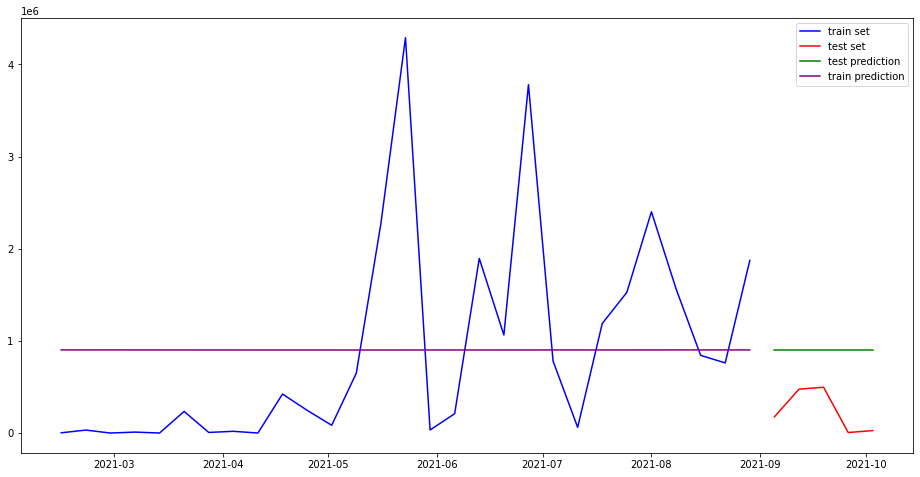

In [265]:
model = SimpleExpSmoothing(train_set.amount).fit(smoothing_level=0.0001)
test_prediction = np.array(model.forecast(5))
train_prediction = model.fittedvalues
plt.figure(figsize=(16,8))
plt.plot(train_set.paidAt,train_set.amount,color='blue',label='train set')
plt.plot(test_set.paidAt,test_set.amount,color='red',label='test set')
plt.plot(test_set.paidAt,test_prediction,color='green',label='test prediction')
plt.plot(train_set.paidAt,train_prediction,color='purple',label='train prediction')
plt.legend()
plt.title("")
plt.show()

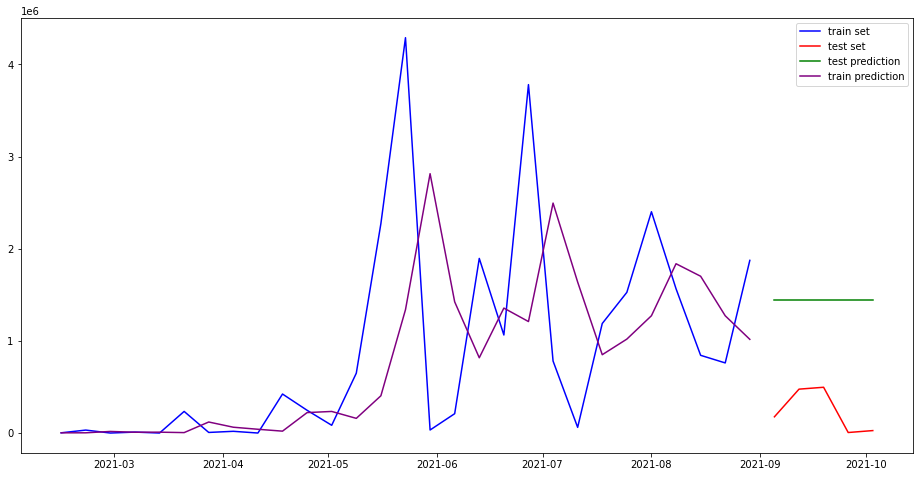

In [266]:
model = SimpleExpSmoothing(train_set.amount).fit(smoothing_level=0.5)
test_prediction = np.array(model.forecast(5))
train_prediction = model.fittedvalues
plt.figure(figsize=(16,8))
plt.plot(train_set.paidAt,train_set.amount,color='blue',label='train set')
plt.plot(test_set.paidAt,test_set.amount,color='red',label='test set')
plt.plot(test_set.paidAt,test_prediction,color='green',label='test prediction')
plt.plot(train_set.paidAt,train_prediction,color='purple',label='train prediction')
plt.legend()
plt.title("")
plt.show()

# ARIMA 

In [267]:
arima_model = auto_arima(train_set.amount,d=1,start_p=0,start_q=0,max_p=5,max_d=5,max_q=5,start_P=0,start_Q=0,max_P=5,max_D=5,max_Q=5,m=4,trace=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=873.598, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=874.401, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=867.799, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=871.684, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=865.912, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=867.458, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=868.430, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=868.193, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=875.033, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=872.942, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=870.345, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4]             : AIC=864.319, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[4]             : AIC=866.300, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4]             : AIC=866.287, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[4]             : AIC=867.6

In [271]:
train_prediction = arima_model.predict_in_sample(train_set.paidAt)
test_prediction = arima_model.predict(5)

In [272]:
mean_squared_error(train_prediction,train_set.amount)**(1/2)


1083625.9322803996

In [273]:
mean_squared_error(test_prediction,test_set.amount)**(1/2)


1163615.3036959714

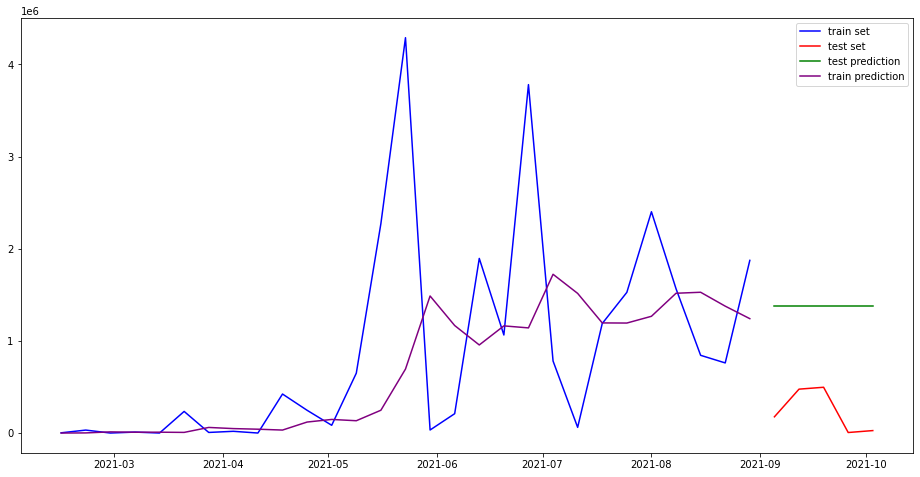

In [274]:
plt.figure(figsize=(16,8))
plt.plot(train_set.paidAt,train_set.amount,color='blue',label='train set')
plt.plot(test_set.paidAt,test_set.amount,color='red',label='test set')
plt.plot(test_set.paidAt,test_prediction,color='green',label='test prediction')
plt.plot(train_set.paidAt,train_prediction,color='purple',label='train prediction')
plt.legend()
plt.title("")
plt.show()

# Support vector regression

In [275]:
c = [10,100,1000,10000,100000,100000,1000000]
g = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
e = [0.001,0.01,0.1,1,10]
df_svr = pd.DataFrame()

a=-1
for i in c:
    for j in g:
        for k in e:
            a=a+1
            rbf_svr = SVR(kernel = 'rbf', C=i, gamma=j,epsilon = k)
            rbf_svr.fit(np.array(train_set.paidAt).reshape(-1,1),np.array(train_set.amount))
            train_prediction = rbf_svr.predict(np.array(train_set.paidAt).reshape(-1,1))
            test_prediction = rbf_svr.predict(np.array(test_set.paidAt).reshape(-1,1))
            rmse_test = mean_squared_error(test_prediction,test_set.amount)**(1/2)
            rmse_train = mean_squared_error(train_prediction,train_set.amount)**(1/2)
            df_svr.loc[a,'C'] = i
            df_svr.loc[a,'gamma'] = j
            df_svr.loc[a,'epsilon'] = k
            df_svr.loc[a,'rmse_test'] = rmse_test
            df_svr.loc[a,'rmse_train'] = rmse_train
                
            

In [276]:
df_svr['rmse_sum']=df_svr['rmse_train']+df_svr['rmse_test']
df_svr.sort_values('rmse_test').head(10)

,C,gamma,epsilon,rmse_test,rmse_train,rmse_sum
0,10.0,0.001,0.001,283187.251264,1.227311e+06,1.510498e+06
225,100000.0,0.010,0.001,283187.251264,1.162240e+06,1.445427e+06
224,100000.0,0.001,10.000,283187.251264,1.162240e+06,1.445427e+06
223,100000.0,0.001,1.000,283187.251264,1.162240e+06,1.445427e+06
222,100000.0,0.001,0.100,283187.251264,1.162240e+06,1.445427e+06
221,100000.0,0.001,0.010,283187.251264,1.162240e+06,1.445427e+06
220,100000.0,0.001,0.001,283187.251264,1.162240e+06,1.445427e+06
219,10000.0,0.900,10.000,283187.251264,1.220610e+06,1.503797e+06
226,100000.0,0.010,0.010,283187.251264,1.162240e+06,1.445427e+06
218,10000.0,0.900,1.000,283187.251264,1.220610e+06,1.503797e+06


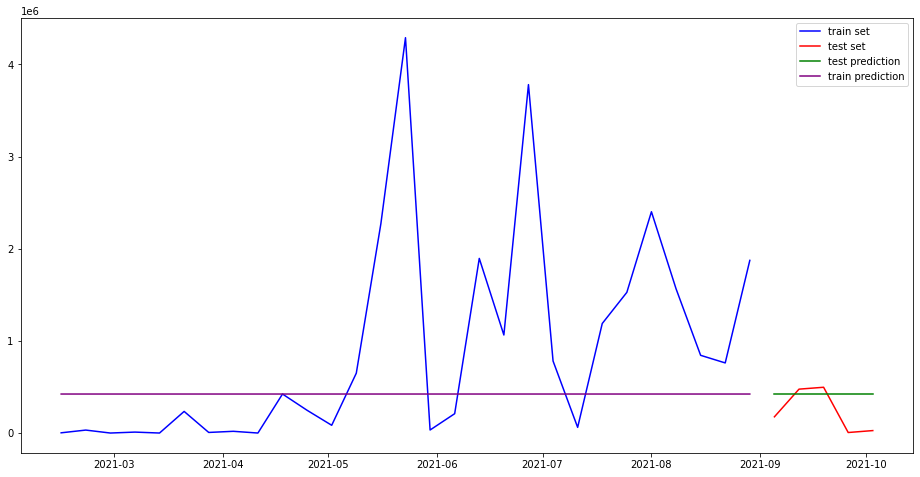

In [277]:
rbf_svr = SVR(kernel = 'rbf', C=10, gamma=0.001,epsilon = 0.001)
rbf_svr.fit(np.array(train_set.paidAt).reshape(-1,1),np.array(train_set.amount))
test_prediction = rbf_svr.predict(np.array(test_set.paidAt).reshape(-1,1))
train_prediction = rbf_svr.predict(np.array(train_set.paidAt).reshape(-1,1))
plt.figure(figsize=(16,8))
plt.plot(train_set.paidAt,train_set.amount,color='blue',label='train set')
plt.plot(test_set.paidAt,test_set.amount,color='red',label='test set')
plt.plot(test_set.paidAt,test_prediction,color='green',label='test prediction')
plt.plot(train_set.paidAt,train_prediction,color='purple',label='train prediction')
plt.legend()
plt.show()     

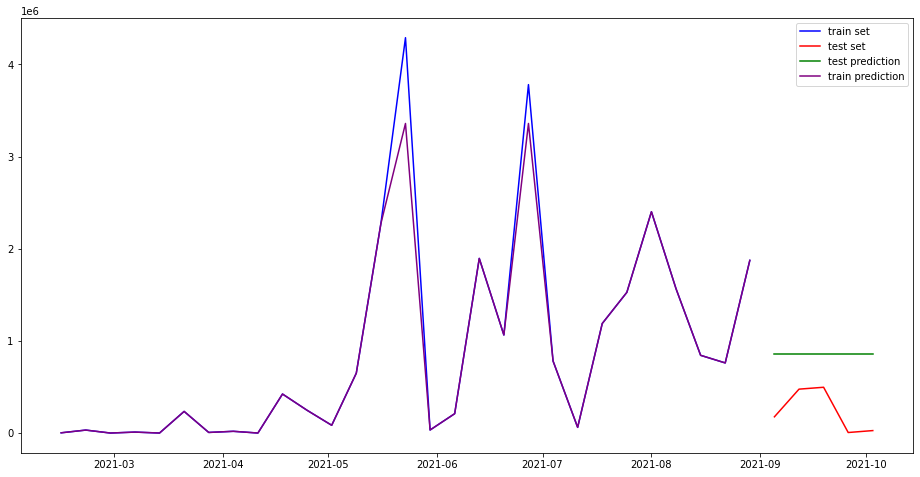

In [278]:
rbf_svr = SVR(kernel = 'rbf', C=2500000, gamma=0.001,epsilon = 0.01)
rbf_svr.fit(np.array(train_set.paidAt).reshape(-1,1),np.array(train_set.amount))
test_prediction = rbf_svr.predict(np.array(test_set.paidAt).reshape(-1,1))
train_prediction = rbf_svr.predict(np.array(train_set.paidAt).reshape(-1,1))
plt.figure(figsize=(16,8))
plt.plot(train_set.paidAt,train_set.amount,color='blue',label='train set')
plt.plot(test_set.paidAt,test_set.amount,color='red',label='test set')
plt.plot(test_set.paidAt,test_prediction,color='green',label='test prediction')
plt.plot(train_set.paidAt,train_prediction,color='purple',label='train prediction')
plt.legend()
plt.show()    

# Model selection 

In [240]:
weekly.amount.median()* 4.4286

1483233.6870449998

In [256]:
lm.predict(np.array(weekly.amount.median()* 4.4286).reshape(-1,1))

array([970878.41771475])

In [243]:
np.array([round(n*q - z*(n*q*(1-q))**(1/2),0),round(n*q + z*(n*q*(1-q))**(1/2),0)])

array([12., 22.])

In [253]:
print(np.array(weekly.amount.sort_values())[11])
print(np.array(weekly.amount.sort_values())[21])

61496.41000000002
760622.2600000001


**90% confidence interval for amount is [372458,3368490] which implies a confidence interval for amount by xepelin of [175673,2320534]**